# Tarea 4 - Deep Learning

## Alumno: Amadeo Gustavo Ancarani

### Tarea Planteada: 
Usando el dataset de CIFAR 100
- Implementar una red convolucional con módulos ResNet
- Implementar en dicha red las optimizaciones vistas hasta ahora

##### 00 - Importo las librerias

In [1]:
pip install PyQt5

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, Input, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MSE, MAE
import PyQt5
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve

from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import seaborn as sns
sns.set()
from skimage import feature
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
from keras.layers import Add
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.losses import SparseCategoricalCrossentropy
from keras.models import Sequential
from keras.layers import Dense

In [3]:
import matplotlib.pyplot as plt
from tensorflow.python.keras.callbacks import LearningRateScheduler
import tensorflow as tf
from tensorflow.keras import backend as K


def show_history(history, metrics=['accuracy']):
    """
    Visualize history
    :param history:
    :return:
    """

    # Plot history: Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss history')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    for metric in metrics:
        # Plot history:
        plt.plot(history.history[metric])
        plt.plot(history.history['val_' + metric])
        plt.title(metric + ' history')
        plt.ylabel(metric + ' value (%)')
        plt.xlabel('No. epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()


def step_decay(epochs_drop):
    def step_decay_fun(epoch):
        initial_lrate = 0.001
        drop = 0.000001
        lrate = initial_lrate * tf.math.pow(drop, tf.math.floor((1+epoch)/epochs_drop))
        return lrate
    return step_decay_fun


def r2_keras(y_true, y_pred):
    """
    Custom R2-score metrics for keras backend
    :param y_true: valor real
    :type y_true: Tensor
    :param y_pred: valor predicho
    :type y_pred: Tensor
    :return: r2 score
    :rtype: tensor
    """
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

#### 01. Importo el dataset

In [4]:
from keras.datasets import cifar100

# Download dataset of CIFAR-100
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

x_train = x_train/255
x_test = x_test/255

# Check the shape of the array
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Number of samples in dataset
print(f"Train: {x_train.shape[0]}")
print(f"Test: {x_test.shape[0]}")

# Data format
print(type(x_train))
print(type(y_train))

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
Train: 50000
Test: 10000
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


#### 02. Presento las imágenes

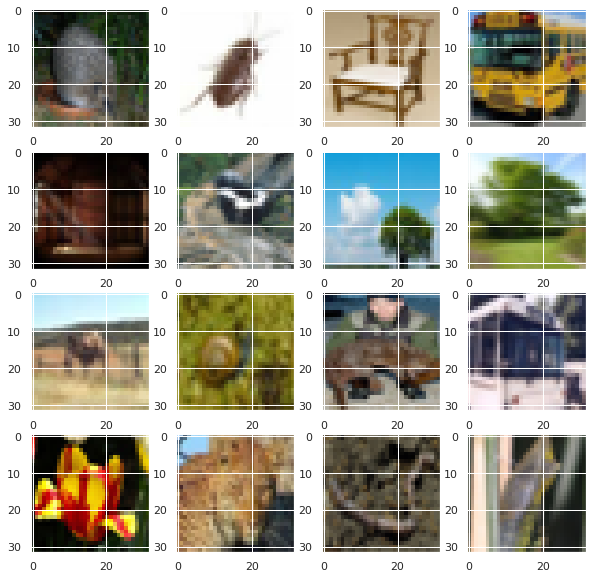

In [ ]:
# Show randomly 16 images in the CIFAR-100
plt.figure(figsize=(10, 10))
for i in range (16):
  rand_num = np.random.randint(0, 50000)
  cifar_img = plt.subplot(4,4, i+1)
  plt.imshow(x_train[rand_num])

#### 03. Comienzo con la red con módulos Resnet

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 flatten (Flatten)              (None, 3072)         0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1500)         4609500     ['flatten[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 1500)        6000        ['dense[0][0]']                  
 alization)                                                                                   

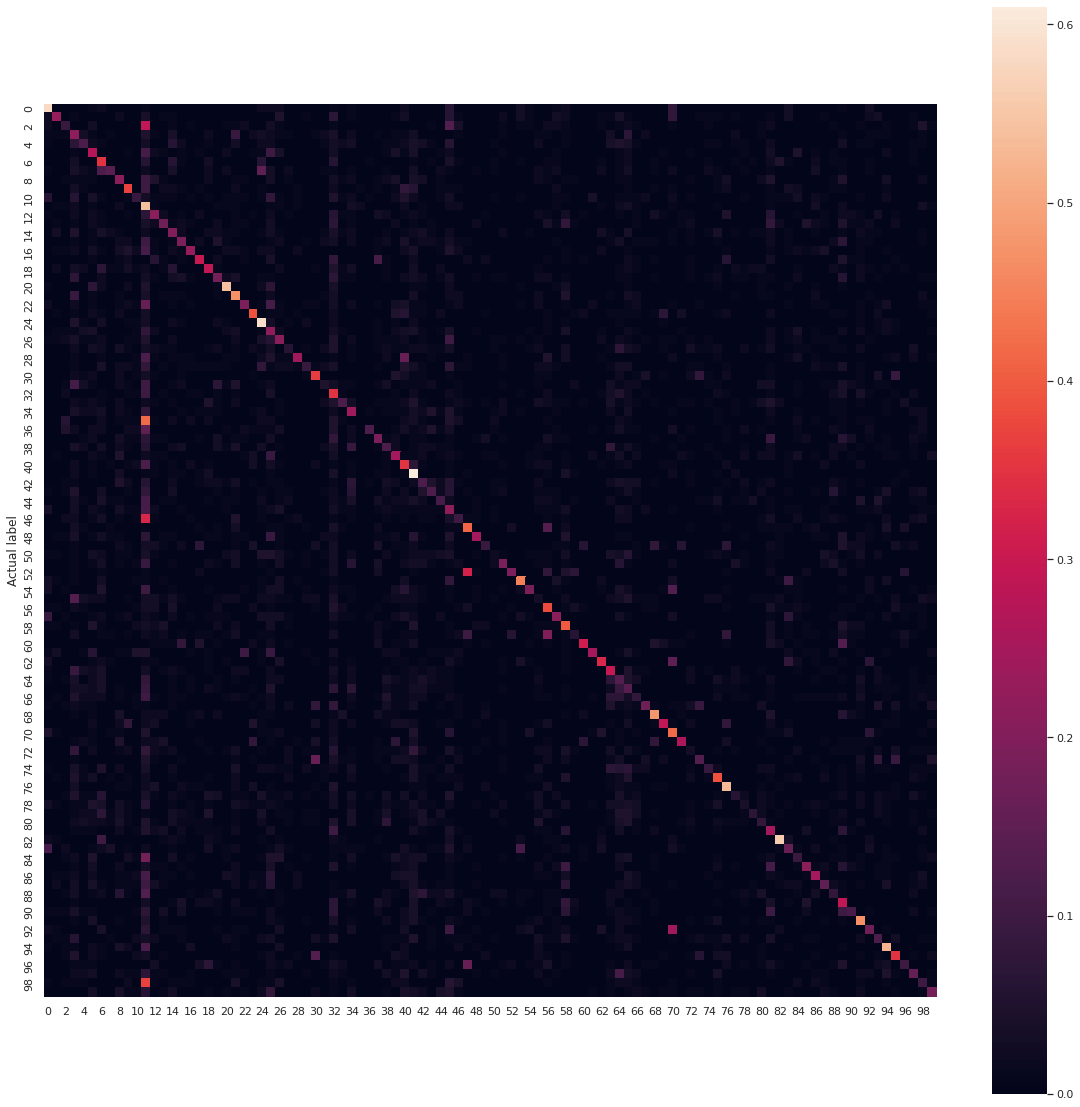

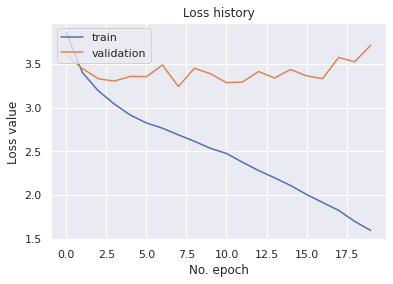

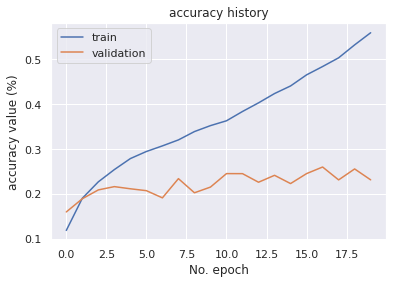

-----------------------------------------------------------


In [ ]:
# capas de la red
input = Input(shape=(32,32,3))
input_flat = layers.Flatten()(input)
input_shortcut = input_flat
layer = layers.Dense(units=1500, activation='relu')(input_flat)
layer = BatchNormalization()(layer)
layer = layers.Dense(units=750, activation='relu')(layer)
layer = BatchNormalization()(layer)
layer = layers.Dense(units=3072, activation='relu')(layer)
layer = tf.keras.layers.Add()([layer, input_shortcut])
layer = BatchNormalization()(layer)
layer = layers.Dense(units=750, activation='relu')(layer)
layer = BatchNormalization()(layer)
layer = layers.Dense(units=3072, activation='relu')(layer)
layer = tf.keras.layers.Add()([layer, input_shortcut])
layer = layers.Dense(units=500, activation='relu')(layer)
output = layers.Dense(units=100, activation='softmax')(layer)

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = SGD(learning_rate=0.01)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(x=x_train, y=y_train, batch_size=30, epochs=20,
                           validation_data=(x_test, y_test))

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=-1)
print('accuracy:', accuracy_score(y_test, y_pred))
print('')
print('recall:', recall_score(y_test, y_pred, average="macro"))
print('')
print('precition score:', precision_score(y_test, y_pred, average="macro"))
print('')
print('F1:', f1_score(y_test, y_pred, average="macro"))
print('')
print('Confusion matrix:')
cm_gbt = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(20,20))
sns.heatmap(cm_gbt, square = True, annot=False)#, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label')

plt.show();
show_history(history)
plt.show();
print('-----------------------------------------------------------')

#### 04. Implementar en dicha red las optimizaciones vistas hasta ahora

Agrego las siguientes optimizaciones:
* BatchNormalization (ya se encontraba en el codigo anterior)
* Dropout
* EarlyStopping


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 3072)         0           ['input_2[0][0]']                
                                                                                                  
 dense_7 (Dense)                (None, 1500)         4609500     ['flatten_1[0][0]']              
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 1500)        6000        ['dense_7[0][0]']                
 rmalization)                                                                               

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


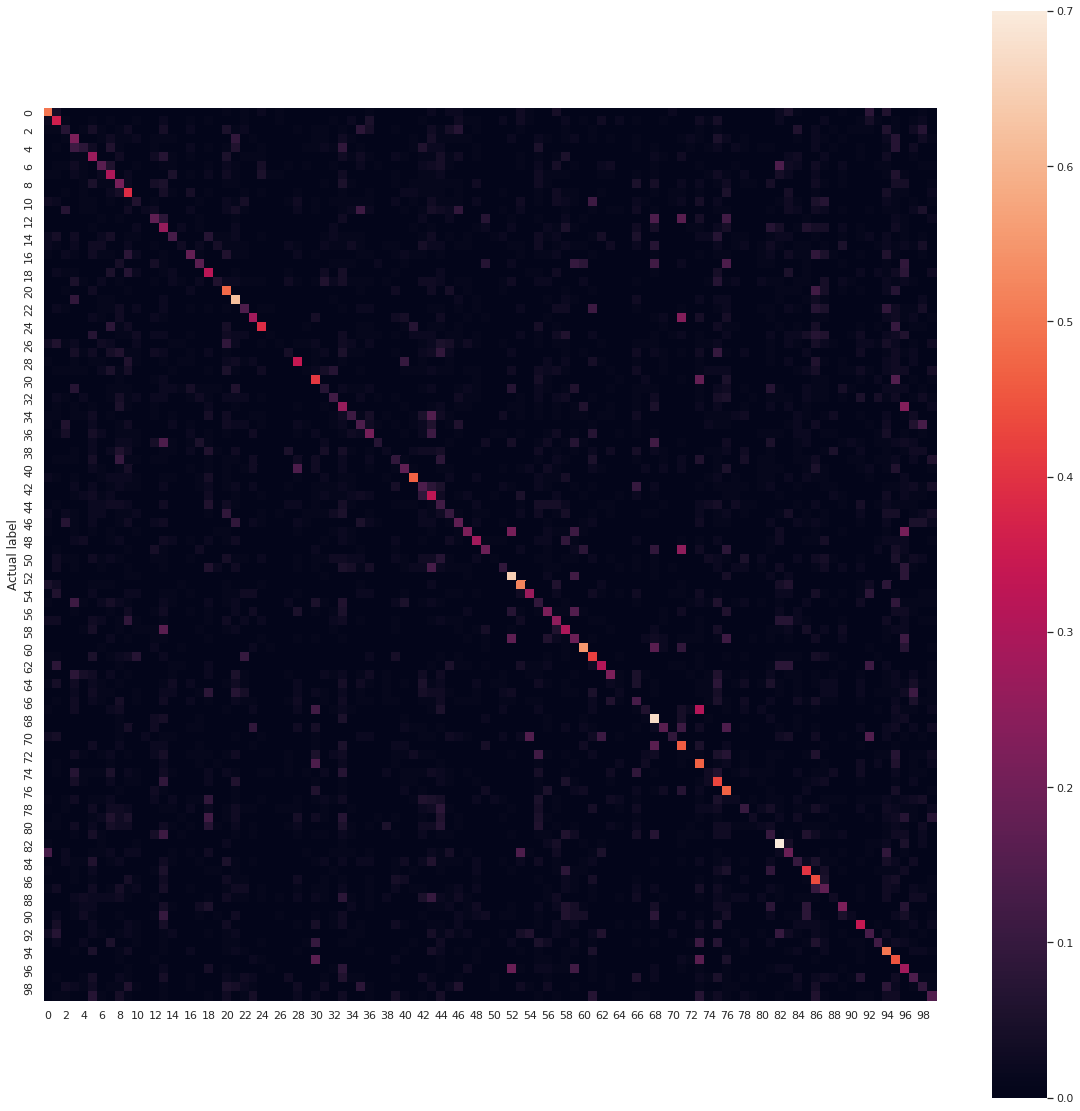

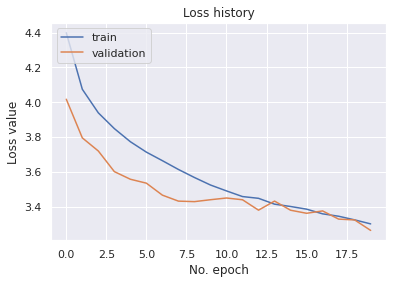

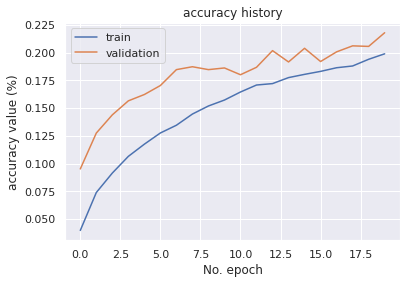

-----------------------------------------------------------


In [ ]:
# capas de la red
input = Input(shape=(32,32,3))
input_flat = layers.Flatten()(input)
input_shortcut = input_flat
layer = layers.Dense(units=1500, activation='relu')(input_flat)
layer = BatchNormalization()(layer)
layer = layers.Dense(units=750, activation='relu')(layer)
layer = BatchNormalization()(layer)
layer = layers.Dense(units=3072, activation='relu')(layer)
layer = tf.keras.layers.Add()([layer, input_shortcut])
layer = BatchNormalization()(layer)
layer = layers.Dense(units=750, activation='relu')(layer)
layer = BatchNormalization()(layer)
layer = layers.Dense(units=3072, activation='relu')(layer)
layer = tf.keras.layers.Add()([layer, input_shortcut])
layer = layers.Dense(units=500, activation='relu')(layer)
layer = Dropout(0.7)(layer)
layer = layers.Dense(units=500, activation='relu')(layer)
output = layers.Dense(units=100, activation='softmax')(layer)

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = SGD(learning_rate=0.01)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)
# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(x=x_train, y=y_train, batch_size=30, epochs=20,
                           validation_data=(x_test, y_test), callbacks=[early_stopping])

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=-1)
print('accuracy:', accuracy_score(y_test, y_pred))
print('')
print('recall:', recall_score(y_test, y_pred, average="macro"))
print('')
print('precition score:', precision_score(y_test, y_pred, average="macro"))
print('')
print('F1:', f1_score(y_test, y_pred, average="macro"))
print('')
print('Confusion matrix:')
cm_gbt = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(20,20))
sns.heatmap(cm_gbt, square = True, annot=False)#, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label')

plt.show();
show_history(history)
plt.show();
print('-----------------------------------------------------------')

# Retos - Deep Learning

## Alumno: Amadeo Gustavo Ancarani

### Tarea Planteada: 

Cada reto resuelto PERFECTAMENTE otorgará 0.5 puntos. Los retos son los siguientes:

1. ¿Por qué la función softmax se puede ver como una generalización de la función sigmoid?

2. ¿Por qué el gradiente de f en un punto cualquiera apunta en la dirección de máximo crecimiento local de f?

3. Diseñar e implementar una función loss que esté asociada a la métrica IoU.

4. Implementar una Clase de python que pueda crear una red, entrenarla y predecir con ella. Además, deberá poseer los métodos necesarios para ser compatible con la función grid_search de scikit-learn.


## Respuestas:

1. ¿Por qué la función softmax se puede ver como una generalización de la función sigmoid?

La función sigmoidea se usa para la regresión logística de dos clases, mientras que la función softmax se usa para la regresión logística multiclase (también conocida como MaxEnt, regresión logística multinomial, regresión softmax, clasificador de entropía máxima).

De hecho, son equivalentes, en el sentido de que la funcion softmax puede transformarse en la funcion sigmoide para el caso de 2 valores posibles para la variable objetivo.

En la regresión logística de dos clases, las probabilidades predichas son las siguientes, utilizando la función sigmoide:

Pr(Yi=0) =  e^(-β⋅Xi) / (1+e^(-β⋅Xi) )

Pr(Yi=1) = 1 - Pr(Yi=0) =  1 / (1+e^(-β⋅Xi))

En la regresión logística multiclase, con K clases, las probabilidades predichas son las siguientes, usando la función softmax:

Pr(Yi=k) =  e^(β_k⋅Xi) / (∑_(0≤c≤K) e^(β_c⋅Xi))

Se puede observar que la función softmax es una extensión de la función sigmoidea al caso multiclase, como se explica a continuación. 

Veamos la regresión logística multiclase, con K= 2:

Pr(Yi=0) =  e^(β_0⋅Xi) / (∑_(0≤c≤K) e^(β_c⋅Xi)) 
         
Pr(Yi=0) =  e^(β_0⋅Xi) / (e^(β_0⋅Xi) + e^(β_1⋅Xi)) 

Pr(Yi=0) = e^((β_0 - β_1)⋅Xi) / (e^((β_0 - β_1)⋅Xi)+1) 

* Pr(Yi=0) = e^(-β⋅Xi) / (e^(-β⋅Xi)+1)

Por otro lado:

Pr(Yi=1) =  e^(β__1⋅Xi) / (∑_(0≤c≤K) e^(β_c⋅Xi))

Pr(Yi=1) =  e^(β_1⋅Xi) / (e^(β_0⋅Xi) + e^(β_1⋅Xi))

Pr(Yi=1) = 1 / (e^((β_0-β_1)⋅Xi)+1)

* Pr(Yi=1) = 1 / (e^(-β⋅Xi)+1)

Con β = - (β0-β1). Vemos que obtenemos las mismas probabilidades que en la regresión logística de dos clases usando la función sigmoidea.

2. ¿Por qué el gradiente de f en un punto cualquiera apunta en la dirección de máximo crecimiento local de f?

Dirección de crecimiento máximo. Una aplicación del vector gradiente.

Si  u,v∈Rn  la **desigualdad de Cauchy-Schwartz** nos dice lo siguiente:

|u⋅v| ≤ ∥u∥∥v∥ 

La igualdad sólo se da si  u  y  v  son proporcionales, es decir, si  v = λu  entonces tenemos que:

u ⋅ v  =  u ⋅ λu = λ ∥u∥ 2 = ∥u∥ ∥λu∥ 

Podemos aplicar esta desigualdad a funciones de varias variables con valores reales.

Si  f:Rn → R  es diferenciable en  Rn, definimos el gradiente de  "f"  en un punto  "a",  "∇f(a)", como el vector de  "n"  dimensiones cuyas componentes son las  "n"  derivadas parciales de  "f"  evaluadas en  "a".

Si  "Duf(a)"  es la derivada direccional de  "f  (en  a) en la dirección  u" , sabemos que se cumple  "Duf(a) = ∇f(a) ⋅ u". Notemos que las derivadas direccionales toman valores reales.

Si usamos la desigualdad de Cauchy-Schwartz, tenemos que:  
|Duf(a)| = |∇f(a ) ⋅u| ≤ ∥∇f(a)∥ ∥u∥ 

De este modo, como hemos dicho al principio, la igualdad se alcanzará si  u = ∇f(a) . Es decir,  |Duf(a)|  será máximo cuando  u=∇f(a).

Esta sencilla deducción nos permite determinar la dirección de crecimiento máximo de  "f  en  a".



3. Diseñar e implementar una función loss que esté asociada a la métrica IoU:


In [ ]:
gl = tfa.losses.GIoULoss()

4. Implementar una Clase de python que pueda crear una red, entrenarla y predecir con ella. Además, deberá poseer los métodos necesarios para ser compatible con la función grid_search de scikit-learn.


In [13]:
class RedNeuronal:
  # capas de la red
  def __init__(self, num_layers, activation_func):

    input = Input(shape=(32,32,3))
    input_flat = layers.Flatten()(input)
    layer = layers.Dense(units=100, activation=activation_func)(input_flat)
    for _ in list(range(1,num_layers+1)):
      layer = layers.Dense(units=100, activation=activation_func)(layer)
      
    output = layers.Dense(units=100, activation='softmax')(layer)

    model = Model(inputs=input, outputs=output)
    self.model = model
  
  
  def compile(self, loss_func, metrics_func, learn_rate, momentum):
    #print(learn_rate)
    optimizer = SGD(learning_rate=learn_rate, momentum=momentum)
    self.model.compile(optimizer=optimizer, loss=loss_func, metrics=[metrics_func])
  
    return self.model

    
  def train(self,learn_rate, momentum, loss_func, metrics_func, x_train, x_test, y_train, y_test):

    param_grid = {'learn_rate':learn_rate, 'momentum':momentum, 'loss_func':loss_func, 'metrics_func':metrics_func}
    #print(param_grid)
    Kmodel = KerasClassifier(build_fn=self.compile, batch_size=30, epochs=20, validation_data=(x_test, y_test))
    grid = GridSearchCV(estimator=Kmodel, param_grid=param_grid, cv=2, scoring="accuracy")

    grid_result = grid.fit(X=x_train, y=y_train)

    self.model = grid_result.best_estimator_
    return grid_result
    
  def results(self):
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    print('mean_test_score', grid_result.cv_results_['mean_test_score'])
    print('std_test_score', grid_result.cv_results_['std_test_score'])
    print('params', grid_result.cv_results_['params'])

  #def fit_grid_params(self):


  def predict(self, x):
      
    y_pred = self.model.predict(x)
    #y_pred = np.argmax(y_pred, axis=-1)

    return y_pred
  
  

In [14]:
red_neuronal1 = RedNeuronal(num_layers=1, activation_func='relu')

In [15]:
red_neuronal1.train([0.01, 0.1], 
                    [0.0, 0.2],
                    [SparseCategoricalCrossentropy()],
                    ['accuracy'],
                    x_train,
                    x_test,
                    y_train,
                    y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


INFO:tensorflow:Assets written to: ram://dc7d890a-9005-474a-8c32-4da503ff5419/assets
INFO:tensorflow:Assets written to: ram://d995e5de-9b82-409e-9a53-70f87eb7b637/assets
Epoch 1/20
834/834 [==============================] - 4s 5ms/step - loss: 4.5470 - accuracy: 0.0224 - val_loss: 4.4525 - val_accuracy: 0.0385
Epoch 2/20
834/834 [==============================] - 4s 5ms/step - loss: 4.2788 - accuracy: 0.0564 - val_loss: 4.1592 - val_accuracy: 0.0611
Epoch 3/20
834/834 [==============================] - 4s 5ms/step - loss: 4.0562 - accuracy: 0.0842 - val_loss: 4.0249 - val_accuracy: 0.0868
Epoch 4/20
834/834 [==============================] - 4s 5ms/step - loss: 3.9330 - accuracy: 0.1042 - val_loss: 3.9174 - val_accuracy: 0.1101
Epoch 5/20
834/834 [==============================] - 4s 5ms/step - loss: 3.8364 - accuracy: 0.1212 - val_loss: 3.8887 - val_accuracy: 0.1111
Epoch 6/20
834/834 [==============================] - 4s 5ms/step - loss: 3.7617 - accuracy: 0.1332 - val_loss: 3.8134 -

GridSearchCV(cv=2,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f839262d690>,
             param_grid={'learn_rate': [0.01, 0.1],
                         'loss_func': [<keras.losses.SparseCategoricalCrossentropy object at 0x7f839262d5d0>],
                         'metrics_func': ['accuracy'], 'momentum': [0.0, 0.2]},
             scoring='accuracy')

accuracy: 0.2234

recall: 0.22339999999999996

precition score: 0.22697340279471928

F1: 0.2050870889516779

Confusion matrix:


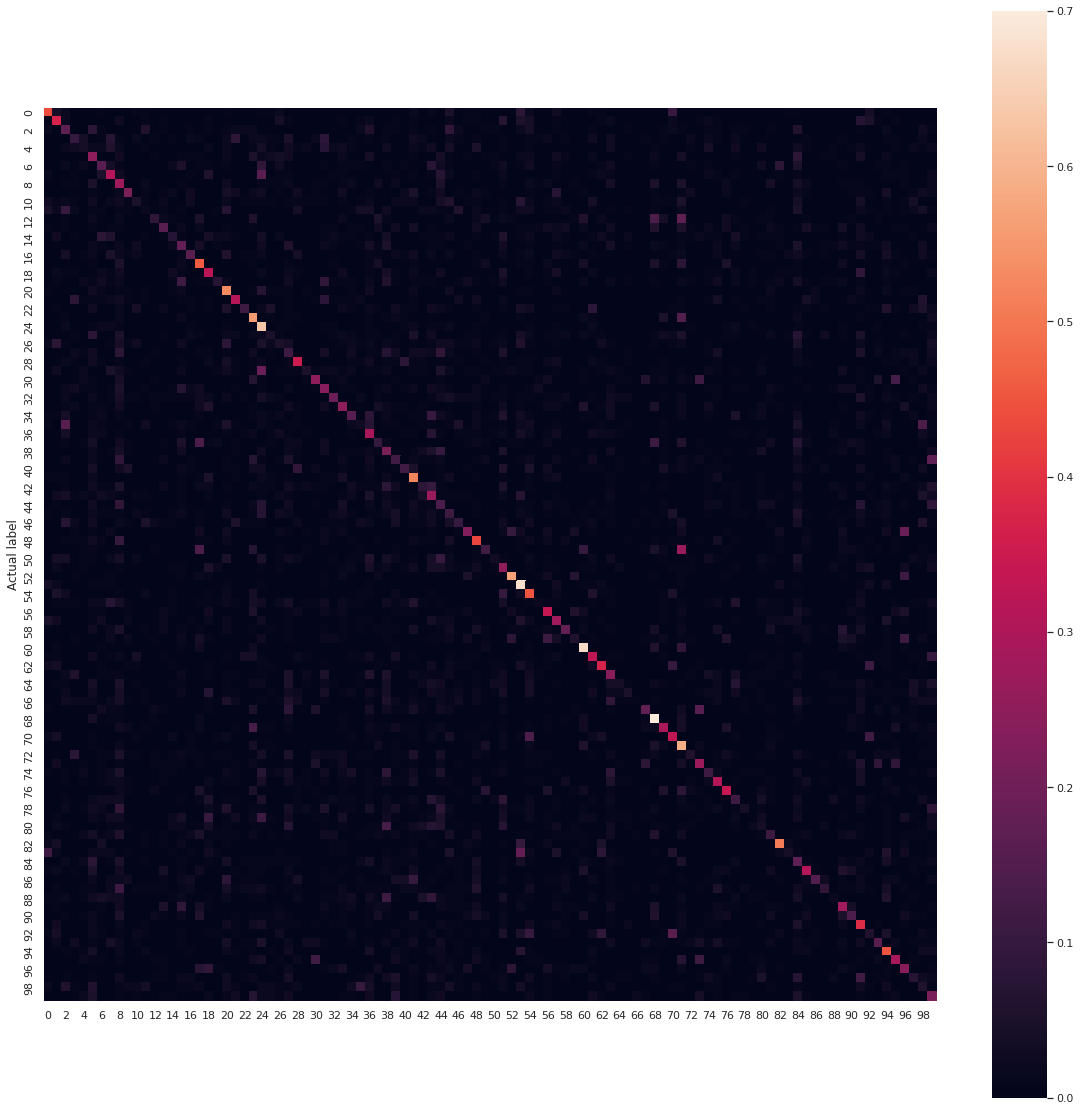

In [19]:
y_pred = red_neuronal1.predict(x_test)
#y_pred = np.argmax(y_pred, axis=-1)
print('accuracy:', accuracy_score(y_test, y_pred))
print('')
print('recall:', recall_score(y_test, y_pred, average="macro"))
print('')
print('precition score:', precision_score(y_test, y_pred, average="macro"))
print('')
print('F1:', f1_score(y_test, y_pred, average="macro"))
print('')
print('Confusion matrix:')
cm_gbt = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(20,20))
sns.heatmap(cm_gbt, square = True, annot=False)#, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label')

plt.show();


In [17]:
print( red_neuronal1.predict(x_test))

[ 8 38 15 ... 18 84 45]
